# One Supporting Fact Model

In [1]:
%matplotlib inline
import importlib, utils2; 
importlib.reload(utils2)
from utils2 import *
import sys

Using TensorFlow backend.
/Users/yonarp/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
np.set_printoptions(4)

In [3]:
cfg = K.tf.ConfigProto(gpu_options = {'allow_growth': True})
K.set_session(K.tf.Session(config = cfg))

In [4]:
def tokenize(sent):
    return [x.strip() for x in re.split('(\W+)?', sent) if x.strip() ]

In [5]:
def parse_stories(lines):
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid,line = line.split(" ",1)
        if int(nid) == 1:story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            substory = None
            substory = [[str(i)+":"]+x for i,x in enumerate(story) if x]
            data.append((substory, q, a))
            story.append('')
        else: story.append(tokenize(line))
    return data

In [6]:
path = get_file('babi-tasks-v1-2.tar.gz', origin = 'https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')

In [7]:
tar = tarfile.open(path)

In [8]:
challenges = {
    # QA1 with 10,000 samples
    'single_supporting_fact_10k': 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt',
    # QA2 with 10,000 samples
    'two_supporting_facts_10k': 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt',
    'two_supporting_facts_1k': 'tasks_1-20_v1-2/en/qa2_two-supporting-facts_{}.txt',
}

In [9]:
challenge_type = 'single_supporting_fact_10k'

challenge = challenges[challenge_type]

In [10]:
def get_stories(file):
    data = parse_stories(file.readlines())
    return [(story, question, answer) for story, question, answer in data]

In [11]:
train_stories = get_stories(tar.extractfile(challenge.format('train')))
test_stories = get_stories(tar.extractfile(challenge.format('test')))

/Users/yonarp/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [12]:
stories = train_stories + test_stories

In [13]:
story_maxlen =    max((len(x) for s,_,_ in stories for x in s))
story_maxsents = max((len(x) for x, _, _ in stories))
query_maxlen = max(len(x) for _, x, _ in stories)

In [14]:
import time
def create_vocab(stories):
    vocab = set()
    for i,story in enumerate(stories):
        sys.stdout.write("\r Running story number: " + str(i))
        
        #Getting vocab from stories
        for text in story[0]:
            [vocab.add(word) for word in text ]
        sys.stdout.flush()
        time.sleep(0.001)
        #getting vocab from questions
        [vocab.add(word) for word in story[1] ]
        
        #Getting vocab from Answer
        vocab.add(story[2])
    return vocab

In [15]:
vocab = sorted(create_vocab(stories))
vocab.insert(0, '<PAD>')
vocab_size = len(vocab)

 Running story number: 10999

In [16]:
story_maxsents, vocab_size, story_maxlen, query_maxlen, len(train_stories), len(test_stories)

(10, 32, 8, 4, 10000, 1000)

In [17]:
word_idx = dict((c, i) for i, c in enumerate(vocab))

In [18]:
def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    X = []; Xq = []; Y = []
    for story, query, answer in data:
        x = [[word_idx[w] for w in s] for s in story]
        xq = [word_idx[w] for w in query]
        y = [word_idx[answer]]
        X.append(x); Xq.append(xq); Y.append(y)
    return ([pad_sequences(x, maxlen=story_maxlen) for x in X],
            pad_sequences(Xq, maxlen=query_maxlen), np.array(Y))

In [19]:
inputs_train, queries_train, answers_train = vectorize_stories(train_stories, 
     word_idx, story_maxlen, query_maxlen)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories, 
     word_idx, story_maxlen, query_maxlen)

In [20]:
def stack_inputs(inputs):
    for i,it in enumerate(inputs):
        inputs[i] = np.concatenate([it, 
                           np.zeros((story_maxsents-it.shape[0],story_maxlen), 'int')])
    return np.stack(inputs)
inputs_train = stack_inputs(inputs_train)
inputs_test = stack_inputs(inputs_test)

In [21]:
inputs_train.shape, inputs_test.shape

((10000, 10, 8), (1000, 10, 8))

In [22]:
inps = [inputs_train, queries_train]
val_inps = [inputs_test, queries_test]

In [23]:
emb_dim = 20
parms = {'verbose': 2}

In [24]:
def emb_sent_bow(inp):
    emb = TimeDistributed(Embedding(vocab_size, emb_dim))(inp)
    return Lambda(lambda x: K.sum(x, 2))(emb)

In [25]:
inp_story = Input((story_maxsents, story_maxlen))
emb_story = emb_sent_bow(inp_story)
inp_story.get_shape(), emb_story.get_shape()

(TensorShape([Dimension(None), Dimension(10), Dimension(8)]),
 TensorShape([Dimension(None), Dimension(10), Dimension(20)]))

In [26]:
inp_q = Input((query_maxlen,))

In [27]:
emb_q = Embedding(vocab_size, emb_dim)(inp_q)
emb_q = Lambda(lambda x: K.sum(x, 1))(emb_q)
emb_q = Reshape((1, emb_dim))(emb_q)
inp_q.get_shape(), emb_q.get_shape()

(TensorShape([Dimension(None), Dimension(4)]),
 TensorShape([Dimension(None), Dimension(1), Dimension(20)]))

In [28]:
x = merge([emb_story, emb_q], mode='dot', dot_axes=2)
x = Reshape((story_maxsents,))(x)
x = Activation('softmax')(x)
match = Reshape((story_maxsents,1))(x)
match.shape

/Users/yonarp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  """Entry point for launching an IPython kernel.
/Users/yonarp/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


TensorShape([Dimension(None), Dimension(10), Dimension(1)])

In [29]:
emb_c = emb_sent_bow(inp_story)
x = merge([match,emb_c], mode='dot', dot_axes=1)
response = Reshape((emb_dim,),)(x)
res = Dense(vocab_size, activation= 'softmax')(response)

/Users/yonarp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
/Users/yonarp/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [30]:
answer = Model([inp_story, inp_q], res)
answer.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [31]:
K.set_value(answer.optimizer.lr, 1e-2)
hist = answer.fit(inps, answers_train, **parms, nb_epoch=4, batch_size=32,
                 validation_data=(val_inps, answers_test))

/Users/yonarp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 10000 samples, validate on 1000 samples
Epoch 1/4
0s - loss: 0.3443 - acc: 0.8945 - val_loss: 0.0023 - val_acc: 0.9990
Epoch 2/4
0s - loss: 0.0046 - acc: 0.9988 - val_loss: 3.1547e-06 - val_acc: 1.0000
Epoch 3/4
0s - loss: 0.0073 - acc: 0.9987 - val_loss: 0.0084 - val_acc: 0.9970
Epoch 4/4
0s - loss: 0.0067 - acc: 0.9994 - val_loss: 0.0025 - val_acc: 0.9990


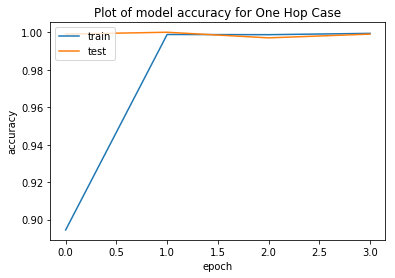

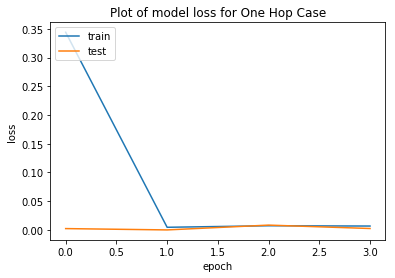

In [35]:
# Visualize training history
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy
# print(history.history.keys())
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Plot of model accuracy for One Hop Case')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Plot of model loss for One Hop Case')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Testing our Model

In [36]:
q_num = 117
f = Model([inp_story, inp_q],match)

In [37]:
train_stories[q_num]

([['0:', 'Mary', 'went', 'back', 'to', 'the', 'hallway', '.'],
  ['1:', 'Daniel', 'went', 'back', 'to', 'the', 'bedroom', '.'],
  ['3:', 'Sandra', 'moved', 'to', 'the', 'bathroom', '.'],
  ['4:', 'Sandra', 'journeyed', 'to', 'the', 'hallway', '.'],
  ['6:', 'Mary', 'went', 'back', 'to', 'the', 'bedroom', '.'],
  ['7:', 'Mary', 'went', 'back', 'to', 'the', 'garden', '.']],
 ['Where', 'is', 'Mary', '?'],
 'garden')

Trying to Predict which sentence has the highest weight on a pretrained model for better understanding

In [38]:
np.squeeze(f.predict([inputs_train[q_num:q_num+1],queries_train[q_num:q_num+1
                                             ]]))[:(len(train_stories[q_num][0]) + 1)]

array([  1.5824e-08,   1.0281e-14,   3.0425e-12,   7.5030e-10,
         1.9646e-01,   8.0354e-01,   3.0973e-16], dtype=float32)

Now applying it to our model

In [39]:
answers_train[q_num:q_num+10,0]

array([21, 27, 27, 22, 25, 20, 20, 20, 25, 19])

In [40]:
np.argmax(answer.predict([inputs_train[q_num:q_num+10], queries_train[q_num:q_num+10]]),1)

array([21, 27, 27, 22, 25, 20, 20, 20, 25, 19])

# Two Supporting Facts

In [41]:
challenge_type = 'two_supporting_facts_10k'
challenge = challenges[challenge_type]
train_stories = get_stories(tar.extractfile(challenge.format('train')))
test_stories = get_stories(tar.extractfile(challenge.format('test')))
stories = train_stories + test_stories
story_maxlen = max((len(s) for x, _, _ in stories for s in x))
story_maxsents = max((len(x) for x, _, _ in stories))
query_maxlen = max(len(x) for _, x, _ in stories)
# vocab = sorted(set(flatten(stories)))
vocab = sorted(create_vocab(stories))
vocab.insert(0, '<PAD>')
vocab_size = len(vocab)
story_maxsents, vocab_size, story_maxlen, query_maxlen, len(train_stories), len(test_stories)

/Users/yonarp/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


 Running story number: 10999

(88, 124, 8, 5, 10000, 1000)

In [42]:
test_stories[534]

([['0:', 'Mary', 'went', 'to', 'the', 'hallway', '.'],
  ['1:', 'Daniel', 'went', 'back', 'to', 'the', 'bedroom', '.'],
  ['2:', 'Sandra', 'went', 'back', 'to', 'the', 'garden', '.'],
  ['3:', 'Mary', 'went', 'to', 'the', 'office', '.'],
  ['4:', 'Mary', 'journeyed', 'to', 'the', 'kitchen', '.'],
  ['5:', 'Sandra', 'moved', 'to', 'the', 'office', '.'],
  ['6:', 'Sandra', 'journeyed', 'to', 'the', 'hallway', '.'],
  ['7:', 'Daniel', 'journeyed', 'to', 'the', 'garden', '.'],
  ['8:', 'Mary', 'journeyed', 'to', 'the', 'bathroom', '.'],
  ['9:', 'John', 'went', 'back', 'to', 'the', 'bathroom', '.'],
  ['10:', 'Sandra', 'travelled', 'to', 'the', 'garden', '.'],
  ['11:', 'John', 'moved', 'to', 'the', 'office', '.'],
  ['12:', 'Daniel', 'went', 'back', 'to', 'the', 'kitchen', '.'],
  ['13:', 'Mary', 'moved', 'to', 'the', 'kitchen', '.'],
  ['14:', 'Mary', 'moved', 'to', 'the', 'hallway', '.'],
  ['15:', 'Mary', 'went', 'to', 'the', 'kitchen', '.'],
  ['16:', 'Sandra', 'went', 'back', 'to', '

In [43]:
word_idx = dict((c, i) for i, c in enumerate(vocab))

In [44]:
inputs_train, queries_train, answers_train = vectorize_stories(train_stories, 
     word_idx, story_maxlen, query_maxlen)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories, 
     word_idx, story_maxlen, query_maxlen)

In [45]:
inputs_train = stack_inputs(inputs_train)
inputs_test = stack_inputs(inputs_test)

In [46]:
inputs_train.shape, inputs_test.shape

((10000, 88, 8), (1000, 88, 8))

In [47]:
inps = [inputs_train, queries_train]
val_inps = [inputs_test, queries_test]

In [48]:
parms = {'verbose': 2}
emb_dim = 30

In [49]:
def emb_sent_bow(inp):
    emb_op = TimeDistributed(Embedding(vocab_size, emb_dim))
    emb = emb_op(inp)
    emb = Lambda(lambda x: K.sum(x, 2))(emb)
#     return Elemwise(0, False)(emb), emb_op
    return emb, emb_op

In [50]:
inp_story = Input((story_maxsents, story_maxlen))
inp_q = Input((query_maxlen,))

In [51]:
emb_story, emb_story_op = emb_sent_bow(inp_story)

In [52]:
emb_q = emb_story_op.layer(inp_q)
emb_q = Lambda(lambda x: K.sum(x, 1))(emb_q)

In [53]:
h = Dense(emb_dim)

In [54]:
def one_hop(u, A):
    C, _ = emb_sent_bow(inp_story)
    x = Reshape((1, emb_dim))(u)
    x = merge([A, x], mode='dot', dot_axes=2)
    x = Reshape((story_maxsents,))(x)
    x = Activation('softmax')(x)
    match = Reshape((story_maxsents,1))(x)

    x = merge([match, C], mode='dot', dot_axes=1)
    x = Reshape((emb_dim,))(x)
    x = h(x)
    x = merge([x, emb_q], 'sum')
    return x, C

In [55]:
response, emb_story = one_hop(emb_q, emb_story)
response, emb_story = one_hop(response, emb_story)

/Users/yonarp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  after removing the cwd from sys.path.
/Users/yonarp/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/yonarp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if __name__ == '__main__':
/Users/yonarp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge

In [56]:
res = Dense(vocab_size, activation='softmax')(response)

In [57]:
answer = Model([inp_story, inp_q], res)
answer.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [58]:
K.set_value(answer.optimizer.lr, 5e-3)
hist=answer.fit(inps, answers_train, **parms, nb_epoch=8, batch_size=64,
           validation_data=(val_inps, answers_test))

/Users/yonarp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 10000 samples, validate on 1000 samples
Epoch 1/8
6s - loss: 1.8319 - acc: 0.2281 - val_loss: 1.5191 - val_acc: 0.4130
Epoch 2/8
5s - loss: 0.8945 - acc: 0.6751 - val_loss: 0.7426 - val_acc: 0.7350
Epoch 3/8
6s - loss: 0.6686 - acc: 0.7556 - val_loss: 0.7736 - val_acc: 0.7040
Epoch 4/8
7s - loss: 0.5826 - acc: 0.7922 - val_loss: 0.7372 - val_acc: 0.7830
Epoch 5/8
6s - loss: 0.5222 - acc: 0.8131 - val_loss: 0.5666 - val_acc: 0.7900
Epoch 6/8
6s - loss: 0.4772 - acc: 0.8389 - val_loss: 0.6351 - val_acc: 0.7870
Epoch 7/8
5s - loss: 0.4463 - acc: 0.8553 - val_loss: 0.5651 - val_acc: 0.8170
Epoch 8/8
6s - loss: 0.4167 - acc: 0.8682 - val_loss: 0.5908 - val_acc: 0.8090


In [59]:
np.array(hist.history['val_acc'])

array([ 0.413,  0.735,  0.704,  0.783,  0.79 ,  0.787,  0.817,  0.809])

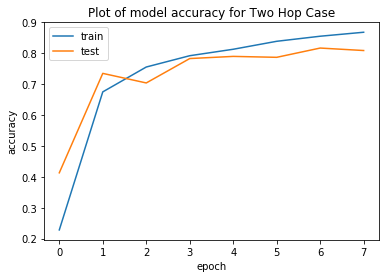

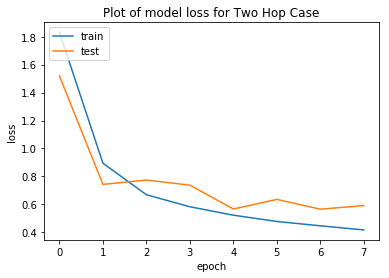

In [61]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Plot of model accuracy for Two Hop Case')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Plot of model loss for Two Hop Case')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()